In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy
import torch
import torch.nn as nn
from fastai.callbacks.hooks import *

In [3]:
PATH = "/project/DSone/as3ek/data/patches/1000/classification/normal_zif__ee_vsi_dn/"
sz = 256
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.1)

In [4]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=sz)
mean_std = data.batch_stats()
data.normalize(mean_std)

ImageDataBunch;

Train: LabelList (67248 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/classification/normal_zif__ee_vsi_dn;

Valid: LabelList (6707 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/classification/normal_zif__ee_vsi_dn;

Test: None

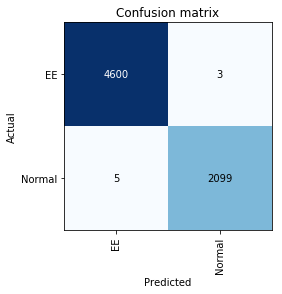

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.load('unfreeze101-epoch-1-meanstdnorm')

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_confusion_matrix()

In [9]:
# hook for Gradcam
def hooked_backward(m,xb,target_layer):
    with hook_output(target_layer) as hook_a:
        preds = m(xb)
        
    return hook_a, preds

In [10]:
def get_features(learn, x):
    x = x.cuda()
    m = learn.model.eval()
    target_layer = m[0][-1][-1]
    f, p = hooked_backward(m, x, target_layer)
    return f, p

In [14]:
ds = interp.data.valid_ds
img_df = ds.to_df()
feat_df = pd.DataFrame()
total = len(img_df)

In [15]:
for index, row in img_df.iterrows():
    x_img = ds.x[index]
    xb, _ = interp.data.one_item(x_img)
    xb_img = Image(interp.data.denorm(xb)[0])
    name = str(row['x']).split('/')[2].split('.')[0]
    
    features, p = get_features(learn, xb)
    features = features.stored[0].cpu().numpy()
    features = features.max(1).max(1)
    
    tmp = pd.DataFrame(data=features).T
    tmp['fname'] = name
    feat_df = pd.concat([feat_df, tmp], ignore_index=True)
    
    if index%1000 == 0:
        print(str(index+1) + '/' + str(total) + ' Complete!')

1/6707 Complete!
1001/6707 Complete!
2001/6707 Complete!
3001/6707 Complete!
4001/6707 Complete!
5001/6707 Complete!
6001/6707 Complete!


In [16]:
feat_df.to_csv('/project/DSone/as3ek/data/csv_files/seem_valid_2048_features_max_normal_zif__ee_vsi_dn.csv', index=False)